In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp
import time

In [52]:
Gamma = 22 # MHz, Decay rate
k = 1/359.3*1e9*2*np.pi #x_0
x0 = 1/k # meter
t0 = 1/Gamma*1/(2*np.pi*1e6) # second
v0 = x0/t0 # m/s
m0 = cts.hbar*t0/x0**2 # kg
a0 = x0/t0**2 # m/s^2
F0 = cts.hbar/(x0*t0) # kg*m/s^2
mass = 43*cts.value('atomic mass constant')/m0 # m_0
waist = 0.012/x0
mag_field_grad = 1000*x0 #G/m
v_max = 4
z_max = 20/x0*1e-3 # meter
z_start = 20/x0*1e-3
dz = 0.5  
dv = 0.5
v_eval = np.arange(1.0,4.0,0.2)
t_eval = np.linspace(0.,2000000.,2000001)
wavelength = 359.3e-9

H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(B=0,
gamma = 50.697/Gamma,b=154.7/Gamma, c=178.5/Gamma,
    muB = cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,return_basis=True
    )

# b : SI coupling(isotropic), c : Iz Sz coupling(anisotropic), cc : I N coupling, gamma : S N coupling

E_X = np.unique(np.diag(H0_X))

H0_A, Bq_A, Abasis = pylcp.hamiltonians.XFmolecules.Astate(
    P=+1, Ahfs=2.4/Gamma, q=0, p=0,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, return_basis=True
    )

# gJ : Lande g-factor, p : parity(e parity)

E_A = np.unique(np.diag(H0_A))

dijq = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    Xbasis, Abasis, UX=U_X
    )

hamiltonian = pylcp.hamiltonian(H0_X, H0_A, Bq_X, Bq_A, dijq,mass = mass)

In [3]:
Isat = np.pi*cts.h*cts.c*Gamma*2*np.pi*1e6/3*1/(wavelength)**3

magField = pylcp.quadrupoleMagneticField(mag_field_grad)

def Fixed_detune_MgF_MOT(s):
    laserBeams = pylcp.laserBeams()
    for ii, Eg_i in enumerate(E_X):
        if ii<2:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=s, delta=(E_A[-1] - Eg_i)-0.5, pol=+1,wb=waist,
                beam_type=pylcp.gaussianBeam
                )
        elif ii==2:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=s, delta=(E_A[-1] - E_X[3])-0.15,pol=+1,wb=waist,
                beam_type=pylcp.gaussianBeam
                )
        else:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=s, delta=(E_A[-1] - Eg_i)-0.5, pol=-1,wb=waist,
                beam_type=pylcp.gaussianBeam
                )

    return laserBeams

In [4]:
# The detunings used in the PRAs:
dets = np.array([-0.25, -0.5, -1, -2])
P = np.array([0.010, 0.040, 0.1, 0.2])
intensities = 2.*P/(np.pi*0.012**2)/Isat
# Make the axis:
z = np.linspace(0, 50/x0, 101)
v = np.linspace(0., 4., 101)

# fig,ax = plt.subplots(1,2,figsize=(13,4))    
# for jj, intensity in enumerate(intensities):
#     laserBeams = Fixed_detune_MgF_MOT(intensity)
#     trap = pylcp.rateeq(laserBeams,magField,hamiltonian,include_mag_forces=0)
#     trap.generate_force_profile(
#         [np.zeros(z.shape), np.zeros(z.shape), z],
#         [np.zeros(z.shape), np.zeros(z.shape), np.zeros(z.shape)],
#         name='Fz')
#     trap.generate_force_profile(
#         [np.zeros(v.shape), np.zeros(v.shape), 1e-12*np.ones(v.shape)],
#         [np.zeros(v.shape), np.zeros(v.shape), v],
#         name='Fv')
#     ax[0].plot(z, trap.profile['Fz'].F[2]/mass*x0/t0**2*1e-3, color='C{0:d}'.format(jj),label = f'{int(1000*P[jj])}mW')
#     ax[1].plot(v*x0/t0, trap.profile['Fv'].F[2]/mass*x0/t0**2*1e-3, color='C{0:d}'.format(jj),label = f'{int(1000*P[jj])}mW')
# ax[0].set_xlabel('$z (mm)$')
# ax[0].set_ylabel('$a\ (km/s)$')
# ax[1].set_xlabel('$v\ (m/s)$')
# ax[0].legend()
# ax[1].legend()
# fig.subplots_adjust(hspace=0.33, wspace=0.175)

# # fig.savefig('20210423_1.png')

In [5]:
zz = np.linspace(-1*z_max,z_max+dz,1000)
vv = np.linspace(-1*v_max,v_max+dv,100)
Z,V = np.meshgrid(zz,vv)

laserBeams = Fixed_detune_MgF_MOT(intensities[3])
magField = pylcp.quadrupoleMagneticField(mag_field_grad)
rateeq = pylcp.rateeq(laserBeams,magField,hamiltonian,include_mag_forces=False)

In [6]:
rateeq.generate_force_profile([np.zeros(Z.shape),np.zeros(Z.shape),Z],[np.zeros(V.shape),np.zeros(V.shape),V],name='F',progress_bar=1)

Completed in 2:27.                                                  


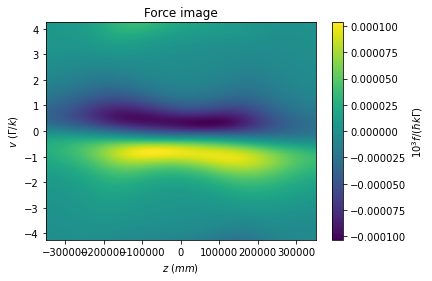

In [20]:
fig, ax = plt.subplots(1, 1)
plt.imshow(rateeq.profile['F'].F[2]/mass, origin='lower',
           extent=(np.amin(zz)-dz/2, np.amax(zz)-dz/2,
                   (np.amin(vv)-dv/2), (np.amax(vv)-dv/2)),
           aspect='auto')
cb1 = plt.colorbar()
cb1.set_label('$10^3f/(\hbar k \Gamma)$')
ax.set_xlabel('$z\ (mm)$')
ax.set_ylabel('$v\ (\Gamma /k)$')
ax.set_title('Force image')
fig.subplots_adjust(left=0.12,right=0.9)

fig.savefig('20210614_6.png')

In [53]:
# See solve_ivp documentation for event function discussion:
def captured_condition(t, y, threshold=1e-1):
    if y[-4]<threshold:
        val = -1.
    else:
        val = 1.

    return val

def lost_condition(t, y, threshold=4.5):
    if y[-4]>threshold:
        val = -1.
    else:
        val = 1.

    return val

captured_condition.terminal=True
lost_condition.terminal=True

In [54]:
sols_rate = list()

start = time.time()

for v0a in v_eval:
    rateeq.set_initial_position_and_velocity(np.array([0.,0.,-1*z_start]),np.array([0.,0.,v0a]))
    rateeq.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))
    
    rateeq.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= [captured_condition,lost_condition],progress_bar = 1,record_force = 1,method='BDF')
    sols_rate.append(rateeq.sol)

Completed in 0.91 s.                                                   


C:\Users\kr\anaconda3\envs\LCP\lib\site-packages\scipy\interpolate\interpolate.py:623: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Completed in 1.55 s.                                                   
Completed in 0.90 s.                                                   
Completed in 1.01 s.                                                   
Completed in 1.01 s.                                                   
Completed in 1.24 s.                                                   
Completed in 1.09 s.                                                   
Completed in 15.61 s.                                                  
Completed in 1.23 s.                                                   
Completed in 1.20 s.                                                   
Completed in 1.42 s.                                                   
Completed in 0.53 s.                                                   
Completed in 0.52 s.                                                   
Completed in 0.53 s.                                                   
Completed in 0.44 s.                                            

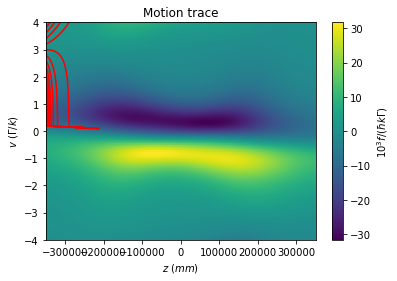

In [55]:
fig, ax = plt.subplots(1, 1)
plt.imshow(1e3*rateeq.profile['F'].F[2], origin='lower',
           extent=(np.amin(zz)-dz/2, np.amax(zz)-dz/2,
                   (np.amin(vv)-dv/2), (np.amax(vv)-dv/2)),
           aspect='auto')
cb1 = plt.colorbar()
cb1.set_label('$10^3f/(\hbar k \Gamma)$')
ax.set_xlabel('$z\ (mm)$')
ax.set_ylabel('$v\ (\Gamma /k)$')
ax.set_title('Motion trace')
ax.set_xlim(-1*z_max,z_max)
ax.set_ylim(-1*v_max,v_max)
fig.subplots_adjust(left=0.12,right=0.9)

for sol in sols_rate:
    ax.plot(sol.r[2],sol.v[2], 'r')

fig.savefig('./picture/20210614_7.png')

In [11]:
print(time.time()-start)

14.118167638778687


In [57]:
for sol in sols_rate:
    if len(sol.t_events[0])==1:
        print('trapped')
    elif len(sol.t_events[1])==1:
        print('lost')
    else:
        print('i don`t know')

trapped
trapped
trapped
trapped
trapped
trapped
trapped
trapped
trapped
trapped
trapped
lost
lost
lost
lost


In [58]:
def is_trapped(v0,z0,eqn, captured_condition, lost_condition, tmax=1000, max_step=np.inf, **kwargs):
    eqn.set_initial_position_and_velocity(np.array([0.,0.,z0]),np.array([0.,0.,v0]))
    if isinstance(eqn,pylcp.rateeq):
        eqn.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))
    
    eqn.evolve_motion([0.,tmax],events = [captured_condition,lost_condition],max_step = max_step)
    
    if len(eqn.sol.t_events[0]) == 1:
        return 1
    else:
        return -1

In [61]:
from scipy.optimize import root_scalar
start = time.time()
vc = root_scalar(is_trapped,bracket=[3.0,3.5],args = (-1*z_start,rateeq,captured_condition,lost_condition,2000000),method = 'brentq')

vc

      converged: True
           flag: 'converged'
 function_calls: 40
     iterations: 39
           root: 3.0640292643020075

In [15]:
# print(time.time()-start)

In [16]:
# vc.root*v0

In [17]:
# # The detunings used in the PRAs:
# dets = np.array([-0.25, -0.5, -1, -2])
# P = np.array([0.010, 0.040, 0.1, 0.2])
# intensities = 2.*P/(np.pi*0.012**2)/Isat
# # Make the axis:
# z = np.linspace(0, 50., 101)
# v = np.linspace(0., 4., 101)

# fig,ax = plt.subplots(1,2,figsize=(13,4))    
# for jj, intensity in enumerate(intensities):
#     laserBeams = Fixed_detune_MgF_MOT(intensity)
#     trap = pylcp.rateeq(laserBeams,magField,hamiltonian,include_mag_forces=0)
#     trap.generate_force_profile(
#         [np.zeros(z.shape), np.zeros(z.shape), z],
#         [np.zeros(z.shape), np.zeros(z.shape), np.zeros(z.shape)*3],
#         name='Fz')
#     trap.generate_force_profile(
#         [np.zeros(z.shape), np.zeros(z.shape), z],
#         [np.zeros(z.shape), np.zeros(z.shape), np.ones(z.shape)*0],
#         name='Fv')
#     ax[0].plot(z, trap.profile['Fz'].F[2]/mass*x0/t0**2*1e-3, color='C{0:d}'.format(jj),label = f'{int(1000*P[jj])}mW')
#     ax[1].plot(v*x0/t0, trap.profile['Fv'].F[2]/mass*x0/t0**2*1e-3, color='C{0:d}'.format(jj),label = f'{int(1000*P[jj])}mW')
# ax[0].set_xlabel('$z (mm)$')
# ax[0].set_ylabel('$a\ (km/s)$')
# ax[1].set_xlabel('$v\ (m/s)$')
# ax[0].legend()
# ax[1].legend()
# fig.subplots_adjust(hspace=0.33, wspace=0.175)

AttributeError: F

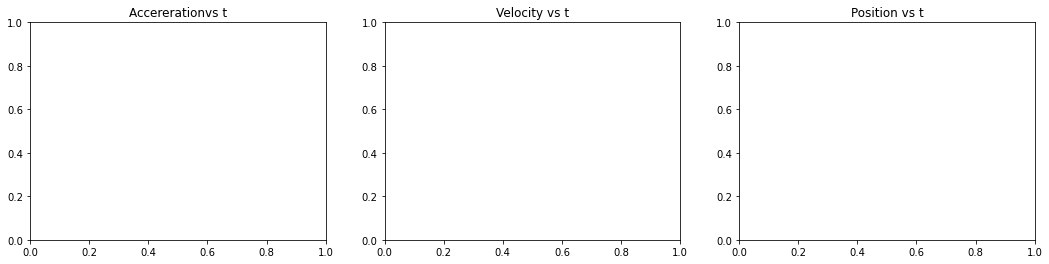

In [18]:
sols = sols_rate[0]
fig, ax = plt.subplots(1,2,figsize=(14,5))

ax[0].set_title('Velocity vs t')
ax[1].set_title('Position vs t')

ax[0].plot(sols.t*t0*1000,sols.v[0]*v0)
ax[1].plot(sols.t*t0*1000,sols.r[0]*1000*x0)

ax[0].set_ylabel('$v (\mathrm{m/s})$')
ax[0].set_xlabel('time $(\mathrm{ms})$')
ax[1].set_ylabel('$x (\mathrm{mm})$')
ax[1].set_xlabel('time $(\mathrm{ms})$')

for i in range(2):
    ax[i].grid()
    
print(sols.v[0][-1])

fig.savefig('./picture/20210614_4.png')

In [ ]:
sols = sols_rate[-1]
fig, ax = plt.subplots(1,2,figsize=(14,5))

ax[0].set_title('Velocity vs t')
ax[1].set_title('Position vs t')

ax[0].plot(sols.t*t0*1000,sols.v[0]*v0)
ax[1].plot(sols.t*t0*1000,sols.r[0]*1000*x0)

ax[0].set_ylabel('$v (\mathrm{m/s})$')
ax[0].set_xlabel('time $(\mathrm{ms})$')
ax[1].set_ylabel('$x (\mathrm{mm})$')
ax[1].set_xlabel('time $(\mathrm{ms})$')

for i in range(2):
    ax[i].grid()
    
print(sols.v[0][-1])
fig.savefig('./picture/20210614_5.png')

In [ ]:
for ii, a in enumerate(sols.v[2]):
    if a>0.2:
        pass
    else:
        print(ii)
        break